# Import Relevant Libraries

In [2]:
import sys, csv, os, json, urllib, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pandas_alive 
import pdb
from itertools import groupby
from time import sleep
from datetime import datetime, date, timedelta

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

plt.rc('axes', unicode_minus=False)
plt.rcParams["font.serif"] = "cmr10"

# Load and clean up data from UNHCR API

In [3]:
#To get applications from API
#Note can also download csv from here: https://www.unhcr.org/refugee-statistics/download/?url=5q9gHV
yearFrom=2000 
yearTo=2020
country='can'
url = "https://api.unhcr.org/population/v1/asylum-applications/?limit=100000&page=&yearFrom="+str(yearFrom)+"&yearTo="+str(yearTo)+"&year=&download=&coo=&coa="+country+"&coo_all=false&coa_all="
with urllib.request.urlopen(url) as urlhtml:
    data = json.loads(urlhtml.read().decode())
df_asylumapps = pd.json_normalize(data, 'items')

#To get decisions from API
yearFrom=2000
yearTo=2020
country='can'
url = "https://api.unhcr.org/population/v1/asylum-decisions/?limit=100000&page=&yearFrom="+str(yearFrom)+"&yearTo="+str(yearTo)+"&year=&download=&coo=&coa="+country+"&coo_all=false&coa_all="
with urllib.request.urlopen(url) as urlhtml:
    data = json.loads(urlhtml.read().decode())
df_asylumdecisions = pd.json_normalize(data, 'items')

#To make CSVs for viewing
df_asylumapps.to_csv('asylum_applications.csv')
df_asylumdecisions.to_csv('asylum_decisions.csv')

In [68]:
#to get demographics from API
yearFrom=2000
yearTo=2020
country='can'
url = "https://api.unhcr.org/population/v1/demographics/?limit=100000&page=&yearFrom="+str(yearFrom)+"&yearTo="+str(yearTo)+"&year=&download=&coo=&coa="+country+"&coo_all=true&coa_all="
with urllib.request.urlopen(url) as urlhtml:
    data = json.loads(urlhtml.read().decode())
df_asylumapps_demo = pd.json_normalize(data, 'items')

In [70]:
#load asylum country list and asylum app data
url = "http://api.unhcr.org/rsq/v1/asylums"
df_asylum = pd.read_json(url)

,code,region,country_name,region_name
0,AFG,Asia and the Pacific,Afghanistan,Asia and the Pacific
1,ALB,Europe,Albania,Europe
2,DZA,Middle East and North Africa,Algeria,Middle East and North Africa
3,AGO,Southern Africa,Angola,Southern Africa
4,ATG,The Americas,Antigua and Barbuda,The Americas
...,...,...,...,...
145,VEN,The Americas,Venezuela (Bolivarian Republic of),The Americas
146,VNM,Asia and the Pacific,Viet Nam,Asia and the Pacific
147,YEM,Middle East and North Africa,Yemen,Middle East and North Africa
148,ZMB,Southern Africa,Zambia,Southern Africa


## Create Asylum Applications Dataframe

In [71]:
#shortening Dem Rep of the Congo to Dem Rep Congo
df_asylumapps['coo_name'] = df_asylumapps['coo_name'].str.replace('Dem. Rep. of the Congo','Dem. Rep. Congo') 

/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
#only include applications under "FI" or "FA" decision levels, excludes only "AR"
df_asylumapps = df_asylumapps[((df_asylumapps['dec_level'] == 'FI') | (df_asylumapps['dec_level'] == 'FA'))]
df_asylumapps 

,Unnamed: 0,year,coo_id,coo_name,coo,coo_iso,coa_id,coa_name,coa,coa_iso,procedure_type,app_type,dec_level,app_pc,applied
0,0,2000,2,Afghanistan,AFG,AFG,33,Canada,CAN,CAN,G,V,FI,P,488
1,1,2000,3,Albania,ALB,ALB,33,Canada,CAN,CAN,G,V,FI,P,665
2,2,2000,4,Algeria,ALG,DZA,33,Canada,CAN,CAN,G,V,FI,P,426
3,3,2000,6,Angola,ANG,AGO,33,Canada,CAN,CAN,G,V,FI,P,589
4,4,2000,7,Antigua and Barbuda,ANT,ATG,33,Canada,CAN,CAN,G,V,FI,P,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3515,3515,2020,202,United States of America,USA,USA,33,Canada,CAN,CAN,G,N,FI,P,345
3517,3517,2020,206,Saint Vincent and the Grenadines,VCT,VCT,33,Canada,CAN,CAN,G,N,FI,P,7
3519,3519,2020,207,Venezuela (Bolivarian Republic of),VEN,VEN,33,Canada,CAN,CAN,G,N,FI,P,289
3520,3520,2020,211,Yemen,YEM,YEM,33,Canada,CAN,CAN,G,N,FI,P,92


In [73]:
#add up all FI and FA applications

years = range(2000,2021,1)
applied_total = []

for i in years:
    for country in df_asylum['country_name']:
        #print(country)
        #parse out data specific to country in year i 
        df_test = df_asylumapps[df_asylumapps['coo_name'] == country]
        #add up all the values in applied section and append to applied_total array 
        applied_total.append([i, country, np.sum(df_test[df_test['year'] == i]['applied'])])

#turn array into dataframe
df_applied_total = pd.DataFrame(applied_total,columns=['year','country','total_applied'])

#add month and year to year index
df_applied_total['year'] = df_applied_total['year'].astype(str) + "-12-31"
df_applied_total

,year,country,total_applied
0,2000-12-31,Afghanistan,488
1,2000-12-31,Albania,665
2,2000-12-31,Algeria,426
3,2000-12-31,Angola,589
4,2000-12-31,Antigua and Barbuda,5
...,...,...,...
3145,2020-12-31,Venezuela (Bolivarian Republic of),289
3146,2020-12-31,Viet Nam,35
3147,2020-12-31,Yemen,92
3148,2020-12-31,Zambia,0


In [74]:
#bar chart race package requires each row to represent particular time and each column a category
#rotate dataframe using df.pivot 
df_applied_pivot = df_applied_total.pivot(index='year',columns='country',values='total_applied')

#calculate cumulative sum of each country over each year so that # of applications in prior years are included 
df_applied_pivot_cs = df_applied_pivot.cumsum() 

#UNHCR asylum dataset begins in 2000 and represents applications applied from Jan 1-Dec 31 of that year 
#initialize dataframe so number starts at 0 on January 1, 2000 when chart begins
df1 = pd.DataFrame([[0] * len(df_applied_pivot_cs.columns)], columns=df_applied_pivot_cs.columns)
df_applied_pivot_cs = df1.append(df_applied_pivot_cs)
df_applied_pivot_cs.rename(index={0:'2000-01-01'},inplace=True)

#convert index to datetime format
df_applied_pivot_cs.index = pd.to_datetime(df_applied_pivot_cs.index)
df_applied_pivot_cs

country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Azerbaijan,Bahamas,...,Ukraine,United Arab Emirates,United Rep. of Tanzania,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2000-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-12-31,488,665,426,589,5,1445,48,0,178,5,...,573,10,189,46,0,98,87,90,0,178
2001-12-31,951,1447,986,1149,10,2901,88,0,329,5,...,917,23,440,91,0,263,155,170,17,2831
2002-12-31,1155,2016,1120,1333,43,3630,105,0,461,5,...,1289,40,567,130,0,593,246,248,28,3088
2003-12-31,1306,2435,1186,1424,57,3868,128,0,584,5,...,1498,40,600,160,0,1212,304,282,39,3158
2004-12-31,1458,2784,1253,1466,70,3955,166,0,640,5,...,1721,45,628,197,0,1486,341,316,56,3253
2005-12-31,1722,3142,1293,1489,75,3998,192,0,667,5,...,1923,45,649,228,0,1591,369,343,68,3936
2006-12-31,1990,3387,1353,1502,85,4042,244,0,690,10,...,2130,50,664,259,0,1691,393,355,73,4518
2007-12-31,2298,3631,1432,1507,85,4068,272,0,702,22,...,2304,55,680,279,0,1839,403,369,93,4757
2008-12-31,2786,4000,1512,1517,101,4104,306,0,713,36,...,2491,60,714,298,0,2009,416,390,105,5144


In [76]:
#calculate total number of asylum applications for each year
total_df_applied = df_applied_pivot_cs.sum(axis=1)

#initializing total # of applications on Jan 1 2000 with end of 2000 numbers since pre-2000 data wasn't collected
total_df_applied['2000-01-01'] = total_df_applied['2000-12-31']

total_df_applied

2000-01-01     31553
2000-12-31     31553
2001-12-31     72350
2002-12-31    108045
2003-12-31    136753
2004-12-31    160255
2005-12-31    179266
2006-12-31    200248
2007-12-31    225490
2008-12-31    257444
2009-12-31    288786
2010-12-31    308665
2011-12-31    330480
2012-12-31    347695
2013-12-31    357082
2014-12-31    368766
2015-12-31    383270
2016-12-31    405163
2017-12-31    448225
2018-12-31    498823
2019-12-31    544428
2020-12-31    557723
dtype: int64

## Create Asylum Decisions Dataframe

In [21]:
# calculate recognition rate data
#shortening Dem Rep of the Congo to Dem Rep Congo
df_asylumdecisions['coo_name'] = df_asylumdecisions['coo_name'].str.replace('Dem. Rep. of the Congo','Dem. Rep. Congo')

#only include applications under "FI" or "FA" decision levels, excludes only "AR"
df_asylumdecisions = df_asylumdecisions[((df_asylumdecisions['dec_level'] == 'FI') | (df_asylumdecisions['dec_level'] == 'FA'))]

#add up all FI and FA applications
years = range(2000,2021,1)
decision_total = []

for i in years:
    for country in df_asylum['country_name']:
        #print(country)
        #parse out data specific to country in year i 
        df_test = df_asylumdecisions[df_asylumdecisions['coo_name'] == country]
        #add up all the values in applied section and append to applied_total array 
        decision_total.append([i, country, np.sum(df_test[df_test['year'] == i]['dec_recognized']),np.sum(df_test[df_test['year'] == i]['dec_rejected']),np.sum(df_test[df_test['year'] == i]['dec_total'])])
        
#turn array into dataframe
df_decision_total = pd.DataFrame(decision_total,columns=['year','country','dec_recognized','dec_rejected','dec_total'])

df_decision_total

,year,country,dec_recognized,dec_rejected,dec_total
0,2000,Afghanistan,436,31,490
1,2000,Albania,336,107,492
2,2000,Algeria,135,257,447
3,2000,Angola,237,100,347
4,2000,Antigua and Barbuda,0,0,0
...,...,...,...,...,...
3145,2020,Venezuela (Bolivarian Republic of),545,54,624
3146,2020,Viet Nam,0,12,39
3147,2020,Yemen,252,0,258
3148,2020,Zambia,0,0,0


In [77]:
#create dataframe reflecting global numbers

#initialize array 
decision_cs = []

# populate array with total sum of decisions recognized, rejected, and decision total
for i in years:
    decision_cs.append([i,df_decision_total[df_decision_total['year']==i].sum()['dec_recognized'],df_decision_total[df_decision_total['year']==i].sum()['dec_rejected'],df_decision_total[df_decision_total['year']==i].sum()['dec_total']])

#convert to dataframe
df_decision_cs = pd.DataFrame(decision_cs,columns=['year','dec_recognized','dec_rejected','dec_total'])

#calculate recognition rate
df_decision_cs['recog_rate']=df_decision_cs.apply(lambda row: (row.dec_recognized*100)/(row.dec_recognized+row.dec_rejected),axis=1)

#convert index into date time format
df_decision_cs['year'] = df_decision_cs['year'].astype(str) + "-12-31"
df_decision_cs = df_decision_cs.set_index('year')

#initialize dataframe so number starts at 0 on January 1, 2000 when chart begins
df2 = pd.DataFrame([[0] * len(df_decision_cs.columns)], columns=df_decision_cs.columns)
df_decision_cs = df2.append(df_decision_cs)
df_decision_cs.rename(index={0:'2000-01-01'},inplace=True)
df_decision_cs.index = pd.to_datetime(df_decision_cs.index)

df_decision_cs

,dec_recognized,dec_rejected,dec_total,recog_rate
2000-01-01,0,0,0,0.000000
2000-12-31,13008,9458,26845,57.900828
2001-12-31,12388,8818,26258,58.417429
2002-12-31,14304,10230,30248,58.302764
2003-12-31,16511,16095,38536,50.637919
2004-12-31,14979,16312,35723,47.869995
2005-12-31,11470,10694,25042,51.750587
2006-12-31,8695,7161,17994,54.837286
2007-12-31,5547,4907,12703,53.061029
2008-12-31,7228,6240,16837,53.667954


In [57]:
#create recognition rate df for easy line graph plotting
df_recognitionrate = df_decision_cs['recog_rate']

#initializing recognition rate on Jan 1 2000 with end of 2000 numbers since pre-2000 data wasn't collected
df_recognitionrate['2000-01-01'] = df_recognitionrate['2000-12-31']
df_recognitionrate

/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


2000-01-01    57.900828
2000-12-31    57.900828
2001-12-31    58.417429
2002-12-31    58.302764
2003-12-31    50.637919
2004-12-31    47.869995
2005-12-31    51.750587
2006-12-31    54.837286
2007-12-31    53.061029
2008-12-31    53.667954
2009-12-31    55.046061
2010-12-31    49.578257
2011-12-31    46.026052
2012-12-31    42.184242
2013-12-31    45.768534
2014-12-31    57.910041
2015-12-31    68.990635
2016-12-31    68.014060
2017-12-31    67.392887
2018-12-31    64.313907
2019-12-31    66.677164
2020-12-31    68.411825
Name: recog_rate, dtype: float64

# Plot Charts

Generating BarChartRace, plotting ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'British Virgin Islands', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Cayman Islands', 'Central African Rep.', 'Chad', 'Chile', 'China', 'China, Hong Kong SAR', 'China, Macao SAR', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Dem. Rep. of the Congo', 'Djibouti', 'Dominican Rep.', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Fiji', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran (Islamic Rep. of)', 'Iraq', 'Israel', 'Jamaica', 'Jordan', 'Kazakhstan', 'Keny

/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/matt/anaconda/envs/py36/lib/python3.6/site-packa

/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/pandas_alive/charts.py:222: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df.columns)
/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/pandas_alive/charts.py:223: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


Generating LineChart, plotting ['0']


/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/pandas_alive/_base_chart.py:440: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df.columns)
/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/pandas_alive/_base_chart.py:441: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


Generating LineChart, plotting ['recog_rate']


/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/pandas_alive/_base_chart.py:291: UserWarning: Attempting to set identical bottom == top == 31553.0 results in singular transformations; automatically expanding.
  .max(skipna=True),
/Users/matt/anaconda/envs/py36/lib/python3.6/site-packages/pandas_alive/charts.py:481: UserWarning: Discarding nonzero nanoseconds in conversion
  super().set_x_y_limits(self.df, i, self.ax)


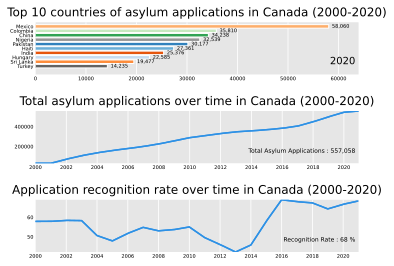

In [78]:
# create two plots
# one bar chart race showing top ten countries filing UNHCR asylum applications to Canada over each year
# second one is a line chart representing total # of asylum claims

#plot bar chart race 
# see here for parameters https://jackmckew.github.io/pandas_alive/generated/pandas_alive.plotting.plot.html
# see here also for bcr package that pandas_alive builds off of 
bar_chart_race = df_applied_pivot_cs.plot_animated(filename='bcr_unhcr_applied.mp4',
                    cmap='tab20c',
                    dpi=300,
                    writer='ffmpeg',
                    n_visible=10,
                    period_fmt="%Y",
                    period_length=2000,
                    interpolate_period=True,
                    shared_fontdict={'family': 'Courier New', 'weight': 'bold',
                                    'color': 'rebeccapurple'},
                    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
                    title_size='8',
                    title='Top 10 countries of asylum applications in Canada (2000-2020)',
                    fixed_max=True,
                    fixed_order=False,
                    steps_per_period=20,
                    label_bars=True,
                    bar_size=.95,
                    #figsize=(16, 9),
                    bar_label_size=5,
                    tick_label_size=5,
                    scale='linear',
                    fig=None,
                    perpendicular_bar_func=False,
                    bar_kwargs={'alpha': .7},
                    filter_column_colors=False) 

# create function that shows cumulative # of asylum applications in line chart plot 
def current_total(values):
    s = f'Total Asylum Applications : {int(values):,}'
    return {'x': .99, 'y': .2, 's': s, 'ha': 'right', 'size': 6}

# plot line chart 
animated_line_chart = total_df_applied.plot_animated(kind='line',
                        #period_label=False,
                        period_length=2000,
                        steps_per_period=20,
                        tick_label_size=5,
                        #figsize=(16,9),
                        period_summary_func = current_total,
                        period_label={'x': .001, 'y': .001, 'ha': 'right', 'va': 'center','size' : 0, 'color' : 'white'},
                        period_fmt="%Y",
                        title="Total asylum applications over time in Canada (2000-2020)"
                        )

def recognition_rate(values):
    s = f'Recognition Rate : {int(values):} %'
    return {'x': .99, 'y': .2, 's': s, 'ha': 'right', 'size': 6}

animated_line_chart2 = df_recognitionrate.plot_animated(kind='line',
                        #fig=fig,
                        #period_label=False,
                        period_length=2000,
                        tick_label_size=5,
                        fixed_max = True,
                        steps_per_period=20,
                        period_summary_func = recognition_rate,
                        period_label={'x': .001, 'y': .001, 'ha': 'right', 'va': 'center','size' : 0, 'color' : 'white'},
                        period_fmt="%Y",
                        title="Application recognition rate over time in Canada (2000-2020)"
                        )
                        
#combine plots 
pandas_alive.animate_multiple_plots('asylum-combined-charts-15.mp4', [bar_chart_race,animated_line_chart,animated_line_chart2], title_fontsize=10, dpi=300,adjust_subplot_wspace=0.7,adjust_subplot_hspace=0.7)